# DCGAN for face generation

 - Antoni Klorek, id: 145454
 - Karol Roszak, id: 145452

Description of the problem: Our problem is to, based on dataset containing human faces, generate new, artificial ones.

In order to acomplish this task we decided to use Deep Convolutional Generative Adversarial Network (DCGAN) model. DCGAN consist of Generator Network and Dyscriminator Network.

Generator network:
 - Given some random noise as input it runs the noise through the differentiable function being a neural network that transform random noise into something of similar structure to the images from the training dataset.
 - Goal of it is to learn distribution of the training dataset to sample out realistic images. The training is performed using second model called discriminator.

Dyscriminator network:
 - It is a classifier network that outputs the probability of an image to be real. It runs on real images, and those generated by GAN outputing the probability of a given image to be real.


 DCGAN differs from traditionall one in the way that instead of using fully connected layers it uses convolution.


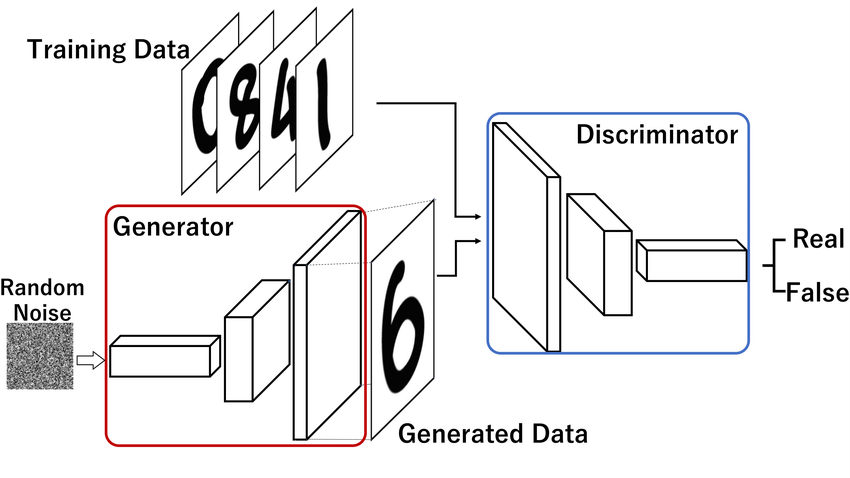

## Report and requirements

REQUIREMENTS:

Problem: GAN (5)

Model:
 - ready architecture trained from scratch (1)
 - own architecture (over 50% of own layers) (2)

Dataset:
 - Evaluation on a set with at least 10000 photos +1 

Training:
 - The correctly selected loss function
 - Split data into train, validation and test set TODO
 - Metrics (at least 2)

Tools:
 - git


Report:
  - description of the data set, with a few image examples\
  - description of the problem\
  - description of used architectures with graphs; model analysis: size in memory, number of parameters\  
  - description of the training\
  - description of used metrics, loss, and evaluation\
  - plots: training and validation loss, metrics\
  - used hyperparameters along with an explanation of each why such value was chosen\
  - comparison of models\
  - list of libraries and tools used\
  - (COLAB PYTHON-> FIRST CELL) a description of the runtime environment\
  - training and inference time,\
  - preparation of a bibliography - the bibliography should contain references to the data set (preferably the article in which the collection was presented) and all scientific works and studies, \
  - including websites with tips on the solution.\
  - analyzes obtained from additional tools




## Imports and necessary steps

In [1]:
# Used python version: 

!python --version

Python 3.7.12


In [5]:
# Importing list of used libraries
# List containing versions of libraries is placed at the end of project

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import regex as re # Regex
import tarfile # Extracting from tar.gz archives
from cv2 import imread # OpenCV
from google.colab.patches import cv2_imshow # in colab to see cv2 images need to use this
from keras.utils.vis_utils import plot_model
import time
from IPython import display

%matplotlib inline

time: 6.64 s (started: 2022-01-26 15:40:12 +00:00)


In [6]:
# Auto measuring execution time

!pip install ipython-autotime

%load_ext autotime


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 5.07 s (started: 2022-01-26 15:40:19 +00:00)


In [ ]:
# Karol's drive
# Accessing google drive -> accessed succesfully!

# mounting_point = '/Immor'

# from google.colab import drive
# drive.mount(mounting_point)

time: 1.44 ms (started: 2022-01-26 09:38:52 +00:00)


In [7]:
# Antek's drive
mounting_point = '/content/drive'
from google.colab import drive
drive.mount(mounting_point)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.96 s (started: 2022-01-26 15:40:24 +00:00)


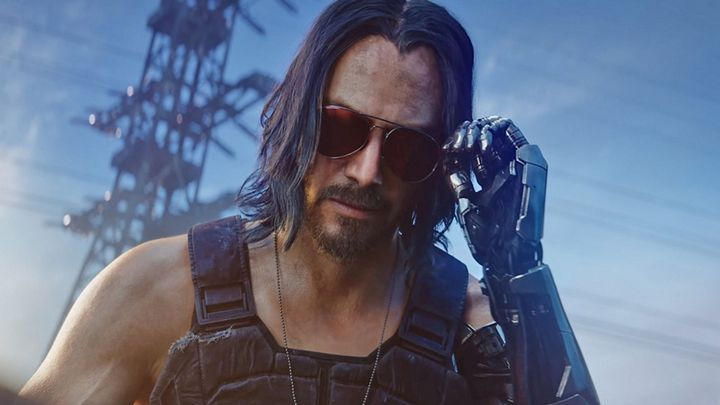

time: 132 ms (started: 2022-01-26 15:40:27 +00:00)


In [8]:
# Checking if the acces to drive works -> if photo of Johny Silverhand appears then it works.

img = imread(mounting_point + '/MyDrive/DCGAN/img_check.jpg') 
cv2_imshow(img)

In [9]:
# Convirmation of usage of GPU in google colab (If no error then set up properly)

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 1.01 s (started: 2022-01-26 15:40:31 +00:00)


## Dataset description and preparation

### Unpacking the dataset (UTKFace) downloaded from https://susanqq.github.io/UTKFace/

Dataset that we have chosen consists of over `20,000` face images with large variation in posees, emotions, perspective, occlusion etc.

Additionally images are labelled by age, gender, and ethnicity, but we decided not to make use of it as the problem we face is already complicated.

Automatic downloading failed as there is no link generated to download the file by the author that our program could use.

In [ ]:
dataset = mounting_point + '/MyDrive/DCGAN/data/UTKFace.tar.gz'
destination_folder = mounting_point + '/MyDrive/DCGAN/data/actual'
num_of_faces = 0

# Create destination folder for unpacking data
try:
  os.makedirs(destination_folder)
except Exception as e:
  print(e)

#If files haven't been unpacked yet then do that
if len(os.listdir(destination_folder)) == 0: 
  # Open archive with data
  archive = tarfile.open(dataset)
  archived_files = archive.getnames()

  for file_name in archived_files:
    # Narrow the dataset a little (still over 10k images)
    # By getting photos of people in ages [23456][012345] (regex expression)
    decision = re.match("^UTKFace/[23456][012345]", file_name)
    if decision: # Extract only specific files matching above condition
      num_of_faces +=1
      archive.extract(file_name, destination_folder)
  print('Number of face photos extracted:', num_of_faces)

  # Close the archive
  archive.close()
else: # Data is unpacked already:
  file_list = os.listdir(destination_folder + '/UTKFace') 
  number_of_files = len(file_list)
  print("Images are unpacked already, number of images:", number_of_files)

[Errno 17] File exists: '/content/drive/MyDrive/DCGAN/data/actual'
Images are unpacked already, number of images: 10439
time: 41.9 s (started: 2022-01-26 09:39:20 +00:00)


### Same examplary images from the dataset:

In [10]:
dataset_images_path = mounting_point + '/MyDrive/DCGAN/data/actual/UTKFace' # path to folder with all dataset images

# examplary loaded images names (NOT PATHS!)
example_img1_path = os.listdir(dataset_images_path)[13]
example_img2_path = os.listdir(dataset_images_path)[1]
example_img3_path = os.listdir(dataset_images_path)[9]
example_img4_path = os.listdir(dataset_images_path)[11]

examplary_imgs_paths = [example_img1_path, example_img2_path, example_img3_path, example_img4_path]

time: 1.69 s (started: 2022-01-26 15:40:37 +00:00)


Image shape: (200, 200, 3)


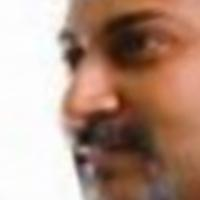

Image shape: (200, 200, 3)


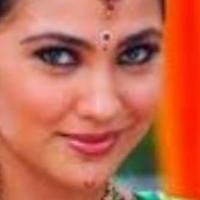

Image shape: (200, 200, 3)


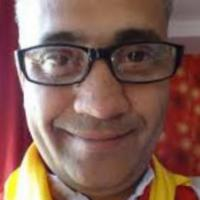

Image shape: (200, 200, 3)


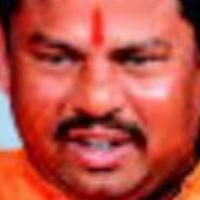

time: 236 ms (started: 2022-01-26 15:40:39 +00:00)


In [11]:
for img_name in examplary_imgs_paths:
  img = imread(dataset_images_path + '/' + img_name) 
  print("Image shape:",img.shape)
  cv2_imshow(img)

# Model1

In [ ]:
dataset_folder = mounting_point + '/MyDrive/DCGAN/data/actual/UTKFace' # Actual 10k+ dataset

# When label=None shape of dataset = (batch_size, image_size[0], image_size[1], num_channels)
dataset = keras.preprocessing.image_dataset_from_directory(
    dataset_folder, label_mode=None, image_size=(64, 64), batch_size=32,
    shuffle = True
)

Found 10439 files belonging to 1 classes.
time: 5.58 s (started: 2022-01-26 11:44:42 +00:00)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# Setting pixel values between [-1, 1] (Model1 uses tanh activation function)
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

time: 10.8 ms (started: 2022-01-26 11:44:47 +00:00)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [ ]:
# Some basic info of keras read dataset
dataset.take(1)

<TakeDataset shapes: (None, 64, 64, 3), types: tf.float32>

time: 4.18 ms (started: 2022-01-26 11:44:49 +00:00)


In [ ]:
# confirming shape of 1 batch from the dataset
# Checking if dataset is normalized [-1,1]
for images in dataset.take(1):
    print(images.shape)
    print(images[0])

(32, 64, 64, 3)
tf.Tensor(
[[[ 0.40392157  0.3254902   0.24705882]
  [ 0.41185662  0.33342525  0.2549939 ]
  [ 0.41960785  0.34117648  0.2627451 ]
  ...
  [-0.08529412 -0.33088234 -0.50539213]
  [-0.0223652  -0.26550245 -0.43020833]
  [ 0.02552083 -0.21761642 -0.37496936]]

 [[ 0.41185662  0.33342525  0.2549939 ]
  [ 0.41988358  0.3414522   0.26302084]
  [ 0.425       0.3465686   0.26813725]
  ...
  [-0.01136642 -0.26188725 -0.44856006]
  [-0.02227328 -0.27325368 -0.45364583]
  [ 0.05588235 -0.19509804 -0.35980392]]

 [[ 0.41960785  0.34117648  0.2627451 ]
  [ 0.425       0.3465686   0.26813725]
  [ 0.427788    0.34935662  0.27092525]
  ...
  [ 0.11329657 -0.1533701  -0.35435048]
  [-0.01868873 -0.2745711  -0.45986518]
  [-0.00471814 -0.26305148 -0.43088236]]

 ...

 [[ 0.52156866  0.4745098   0.38039216]
  [ 0.52156866  0.4745098   0.38039216]
  [ 0.52156866  0.4745098   0.38039216]
  ...
  [ 0.4308211   0.06246936 -0.12619485]
  [ 0.42107844  0.01522672 -0.17696078]
  [ 0.38955268 -0

## Defining a model

### Generator
Generator network:
 - Given some random noise as input it runs the noise through the differentiable function being a neural network that transform random noise into something of similar structure to the images from the training dataset.
 - Goal of it is to learn distribution of the training dataset to sample out realistic images. The training is performed using second model called discriminator.


The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a random noise. Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size.

In [ ]:
def make_generator_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(8*8*128,input_shape=(100,),use_bias=False))    # creates output shape of 8,8 with number of neurons - [8,8,128]
    model.add(layers.BatchNormalization())    # applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
    model.add(layers.LeakyReLU())    # LeakyReLu activation function
    
    model.add(layers.Reshape((8,8,128)))
    assert model.output_shape == (None, 8, 8, 128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(1,1),padding='same',use_bias=False))    # stride (1,1) keeps the same shape as that of input
    assert model.output_shape == (None, 8, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))    # stride (2,2) doubles the size of the input 
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))    # stride (2,2) doubles the size of the input 
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',activation='tanh',use_bias=False))    # stride (2,2) doubles the size of the input
    assert model.output_shape == (None, 64, 64, 3)
    
    return model

time: 23.4 ms (started: 2022-01-26 11:50:34 +00:00)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 8192)              819200    
                                                                 
 batch_normalization_12 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_4 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_14 (Conv2D  (None, 8, 8, 64)         204800    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 8, 8, 64)        

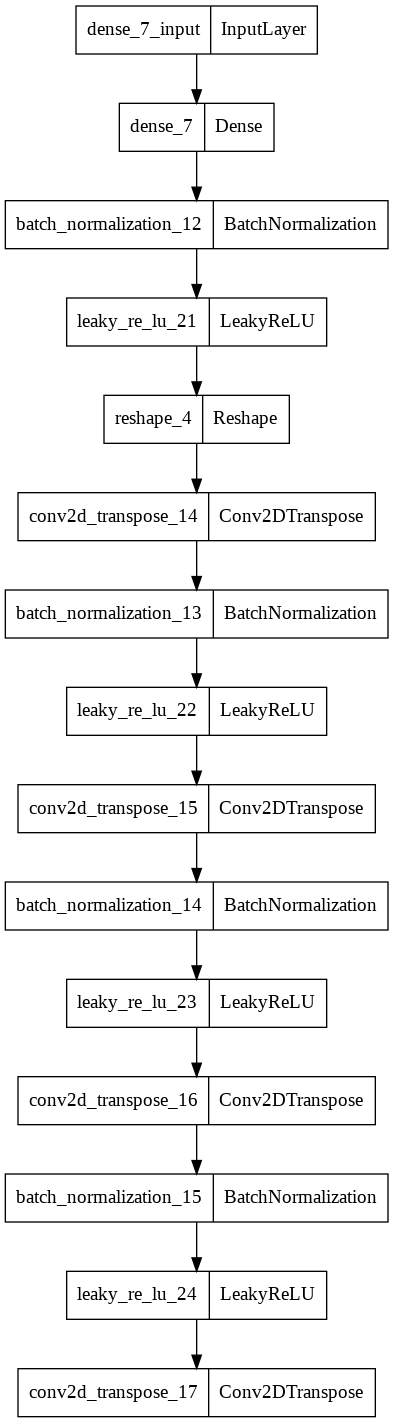

time: 537 ms (started: 2022-01-26 11:45:29 +00:00)


In [ ]:
# Initialize the generator and show summary
generator = make_generator_model()
generator.summary()

# Save and show a generator's graph
tf.keras.utils.plot_model(
generator, to_file='generator.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
gen_img = imread('generator.png')
cv2_imshow(gen_img)

# Generate noise
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)


### Discriminator
Discriminator network:

It is a classifier network that outputs the probability of an image to be real. It runs on real images, and those generated by GAN outputing the probability of a given image to be real.


The discriminator is a CNN-based image classifier. The model will be trained to output positive values for real images, and negative values for fake images.

In [ ]:
def make_discriminator_model():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[64,64,3]))    # stride (2,2) doubles the size of the input
  model.add(layers.LeakyReLU())    #LeakyReLu activation function
  model.add(layers.Dropout(0.3))    # randomly sets input units to 0 with a frequency of 0.3 at each step during training time, which helps prevent overfitting

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))    # stride (2,2) doubles the size of the input
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())    # flattens the input, does not affect the batch size
  model.add(layers.Dense(1))    # regular densely-connected NN layer

  return model

time: 7.18 ms (started: 2022-01-26 11:50:28 +00:00)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 16, 16, 128)       0         
                                                                 
 flatten_3 (Flatten)         (None, 32768)            

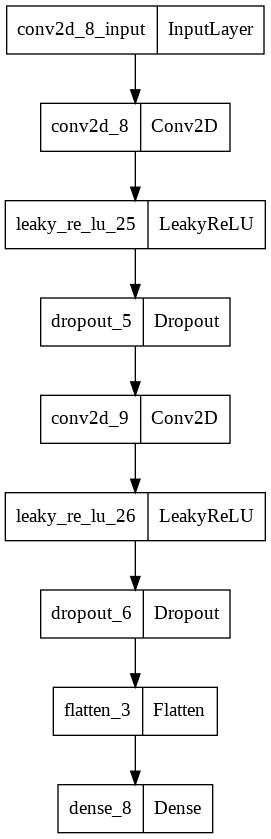

tf.Tensor([[0.00088371]], shape=(1, 1), dtype=float32)
time: 234 ms (started: 2022-01-26 11:47:17 +00:00)


In [ ]:
# Initialize discriminator
discriminator = make_discriminator_model()
discriminator.summary()

# Save and show a generator's graph
tf.keras.utils.plot_model(
discriminator, to_file='discriminator.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
dis_img = imread('discriminator.png')
cv2_imshow(dis_img)

# Examplary decision on the noise image
decision = discriminator(generated_image)
print(decision)

### Loss and optimizers
For both, Generator and Discriminator, BinaryCrossentropy is used as a loss metric.

<b>Discriminator loss</b><br>
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

<b>Generator loss</b><br>
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
  # Calculate real and fake losses and return a total loss
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  # Calculate generator loss
  return cross_entropy(tf.ones_like(fake_output),fake_output)

# Both optimizers are Adam optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Create checkpoint for saving the learned model
checkpoint_dir = mounting_point + '/MyDrive/DCGAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


time: 8.52 ms (started: 2022-01-26 11:50:51 +00:00)


## Training loop

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

Small batch size:<br>
"While training your GAN use a batch size smaller than or equal to 64. Using a bigger batch size might hurt the performance because during the initial training the discriminator might get a lot of examples to train on and it might overpower the generator, which would have a negative effect on training" 

In [ ]:
tf.config.run_functions_eagerly(True) # To get value from a tensor representation
BATCH_SIZE = 32 # Batch size
EPOCHS = 100 # Number  of epochs
noise_dims = 100 # Noise dimensions
num_egs_to_generate = 1 # number of examples to generate during training an epoch
seed = tf.random.normal([num_egs_to_generate,noise_dims])

# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, gen_losses, disc_losses, epoch):
  noise = tf.random.normal([BATCH_SIZE,noise_dims])

  #  tf.GradientTape API is for automatic differentiation - computing the gradient of a computation with respect to some inputs
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    # Generator generates an image
    generated_images = generator(noise,training=True)

    # Discriminator gets real image
    real_output = discriminator(images,training=True)
    # Discriminator gets fake generated image
    fake_output = discriminator(generated_images,training=True)

    # Generator loss on a given image
    gen_loss = generator_loss(fake_output)
    # Discriminator loss on real vs fake image
    disc_loss = discriminator_loss(real_output,fake_output)
  
  # Arrays for storing losses
  gen_losses[epoch].append(gen_loss.numpy())
  disc_losses[epoch].append(disc_loss.numpy())


  gen_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
  dis_gradients = dis_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(dis_gradients,discriminator.trainable_variables))


def train(dataset,epochs):
  # Measure time for training
  start_training = time.time()
  # Arrays for storing losses
  gen_losses = []
  disc_losses = []
  # Train for each epoch
  for epoch in range(epochs):
    gen_losses.append([])
    disc_losses.append([])
    start = time.time()
    for batch in dataset:
      train_step(batch, gen_losses, disc_losses, epoch)
    display.clear_output(wait=True)
    generate_and_save_output(generator,epoch+1,seed)

    # Save checkpoint every 10 epochs
    if (epoch+1)%10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start}')
  
  display.clear_output(wait=True)
  generate_and_save_output(generator,epochs,seed)
  # Show training time
  print(f'Time for training: {time.time()-start_training}')
  return gen_losses, disc_losses


def generate_and_save_output(model,epoch,test_input):

  predictions = model(test_input,training=False)

  # Display image and time for a given epoch, save an image
  for i in range(predictions.shape[0]):
    plt.imshow((predictions[i]*127.5+127.5).numpy().astype(np.uint8))
    plt.axis('off')
  plt.savefig(mounting_point + f'/MyDrive/DCGAN/generated/Model1/image_at_epoch_{epoch}.png')
  plt.show()

time: 57.4 ms (started: 2022-01-26 11:50:58 +00:00)


### Train

Call the train() method to train the generator and discriminator simultaneously. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real.

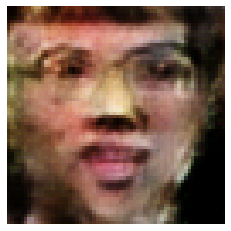

Time for training: 3696.7821526527405
time: 1h 1min 36s (started: 2022-01-26 11:51:08 +00:00)


In [ ]:
g_l, d_l = train(dataset,EPOCHS)

## Model1 results
Training time: 1h1min

### Losses visualization

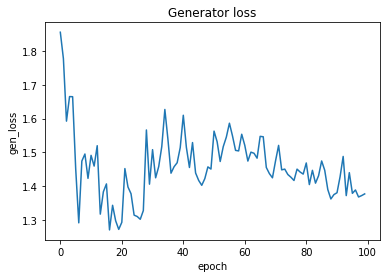

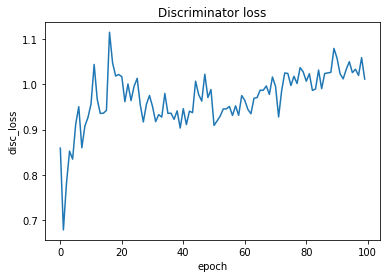

time: 282 ms (started: 2022-01-26 12:53:01 +00:00)


In [ ]:
for i in range(len(g_l)):
  g_l[i] = sum(g_l[i])/len(g_l[i])

for i in range(len(d_l)):
  d_l[i] = sum(d_l[i])/len(d_l[i])

# Plot generator losses
ypoints = np.array(g_l)

plt.plot(ypoints)
plt.xlabel('epoch') 
plt.ylabel('gen_loss') 
  
plt.title("Generator loss")
plt.savefig(mounting_point + '/MyDrive/DCGAN/generated/Model1/losses/dgen1_losses.png')
plt.show()

# Plot discriminator losses
ypoints = np.array(d_l)

plt.plot(ypoints)
plt.xlabel('epoch') 
plt.ylabel('disc_loss') 
  
plt.title("Discriminator loss")
plt.savefig(mounting_point + '/MyDrive/DCGAN/generated/Model1/losses/disc1_losses.png')
plt.show()

### Create a new image

Trained generator now can be used to create new images (faces) that arise from a noise.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


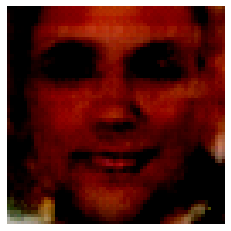

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


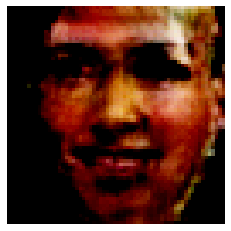

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


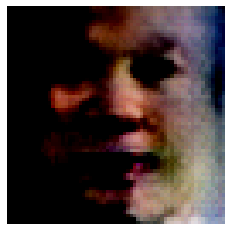

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


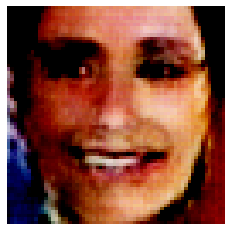

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


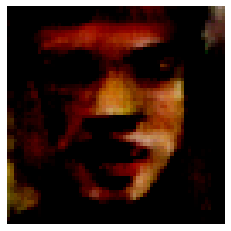

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


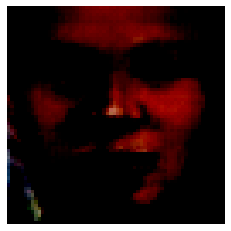

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


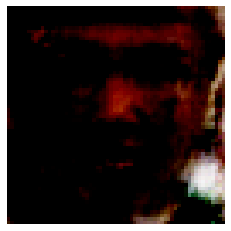

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


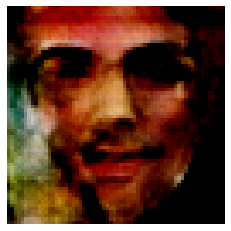

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


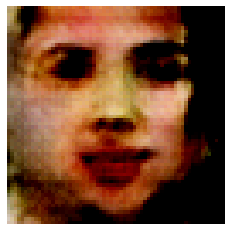

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


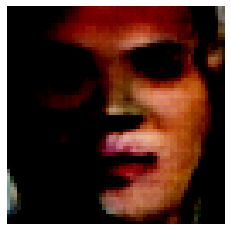

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


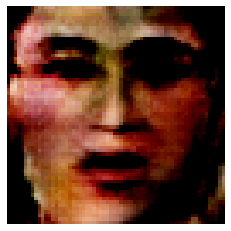

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


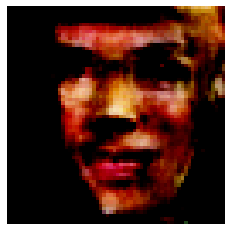

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


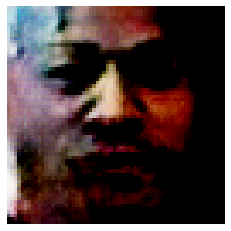

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


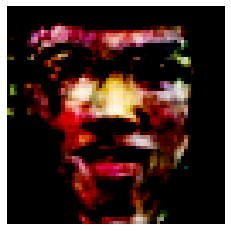

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


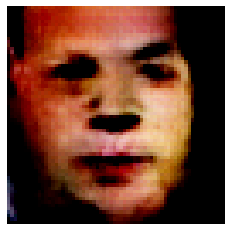

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


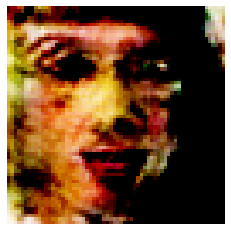

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


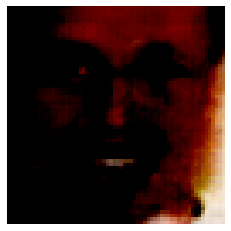

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


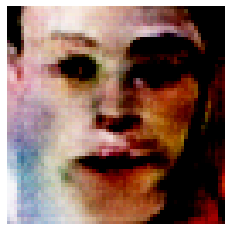

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


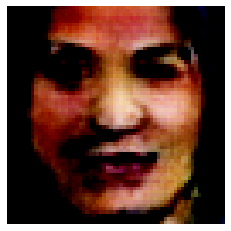

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


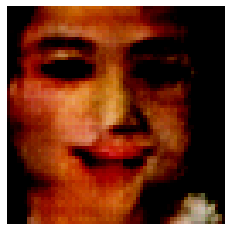

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


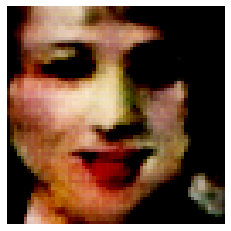

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


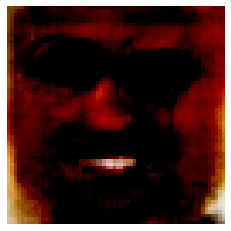

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


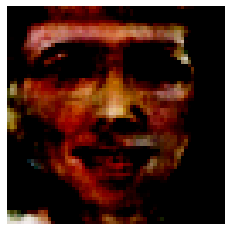

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


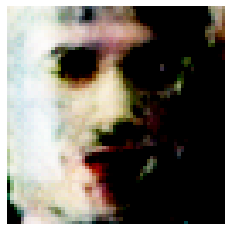

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


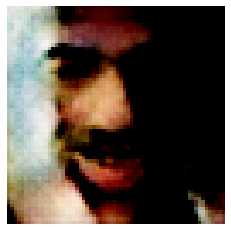

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


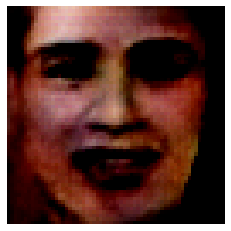

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


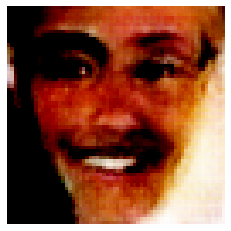

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


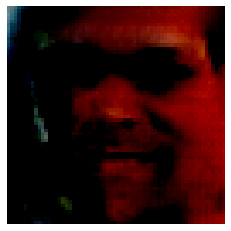

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


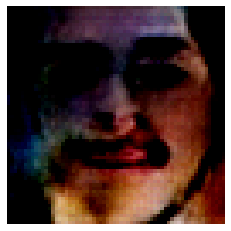

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


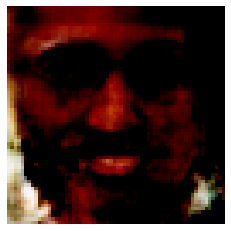

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


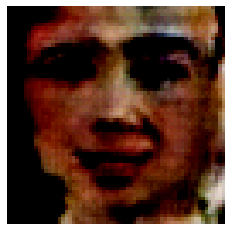

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


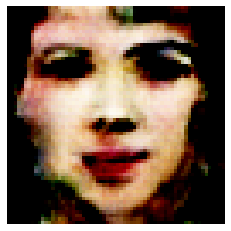

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


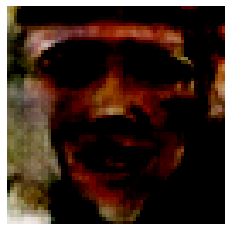

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


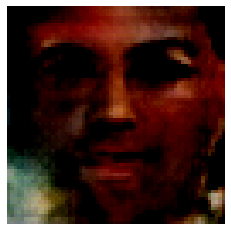

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


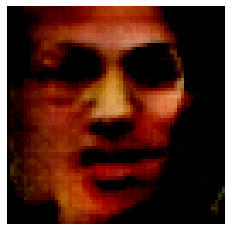

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


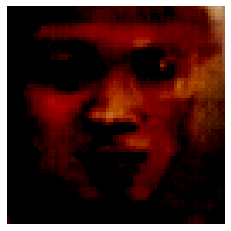

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


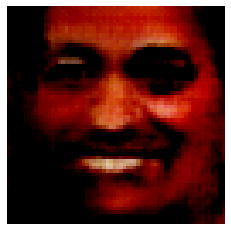

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


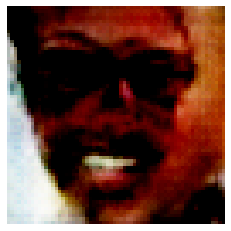

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


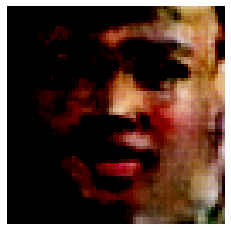

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


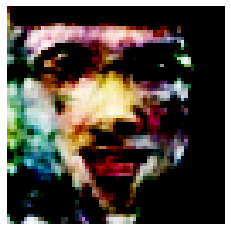

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


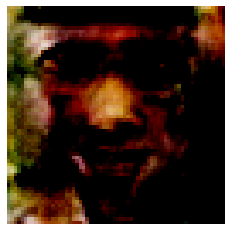

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


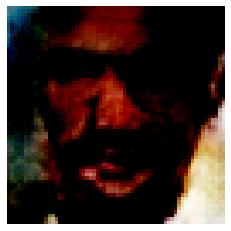

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


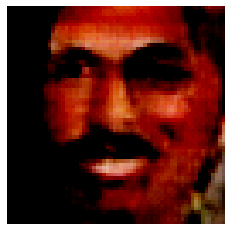

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


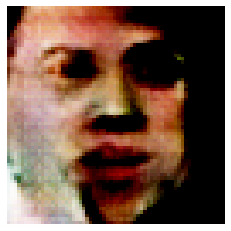

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


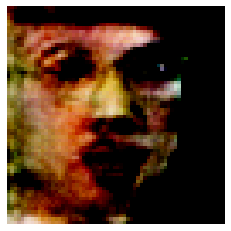

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


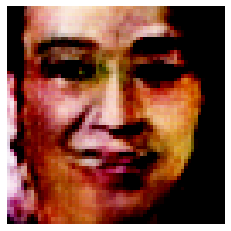

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


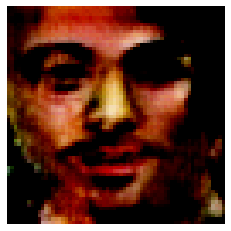

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


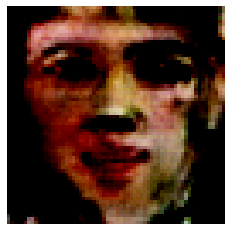

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


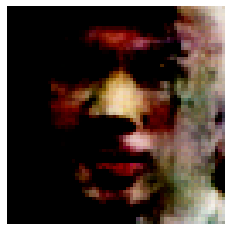

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


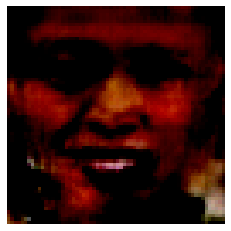

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


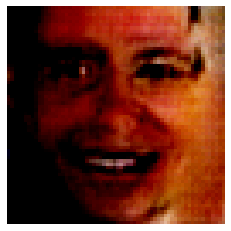

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


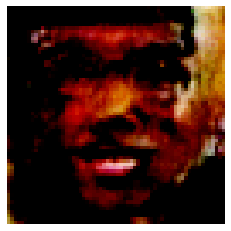

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


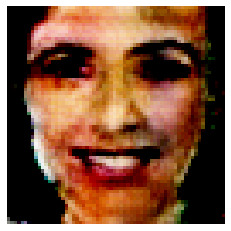

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


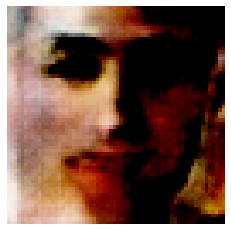

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


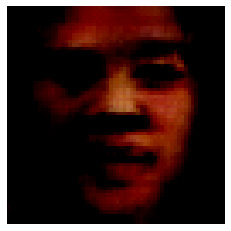

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


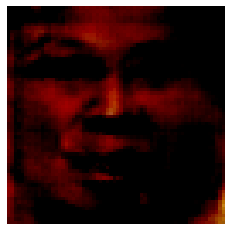

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


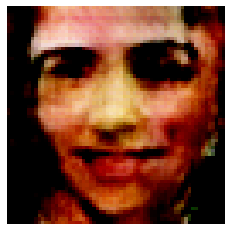

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


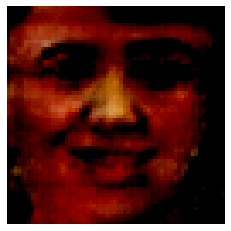

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


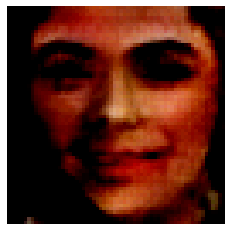

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


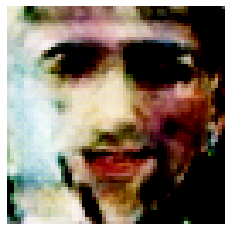

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


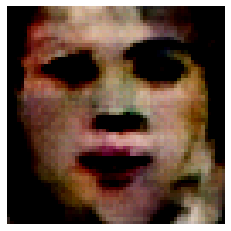

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


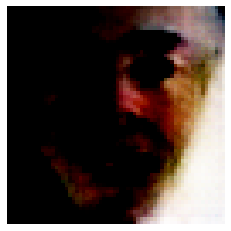

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


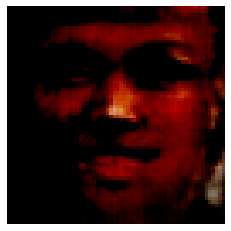

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


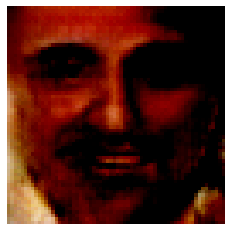

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


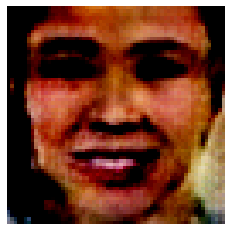

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


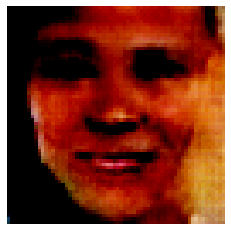

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


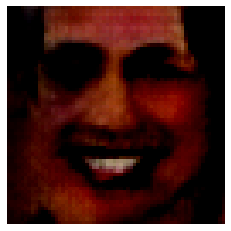

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


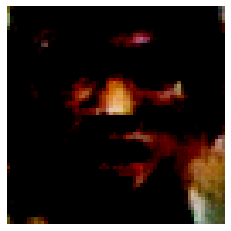

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


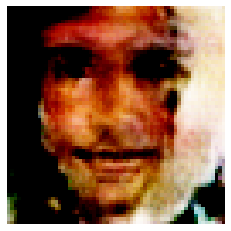

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


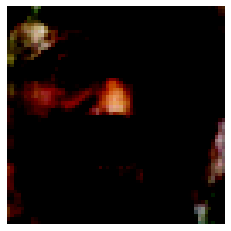

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


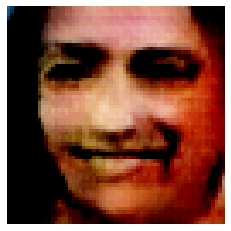

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


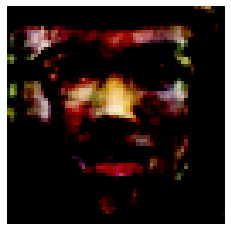

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


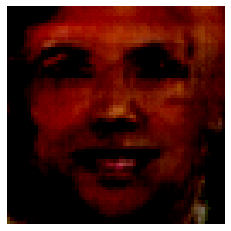

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


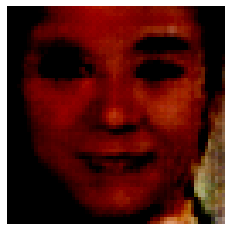

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


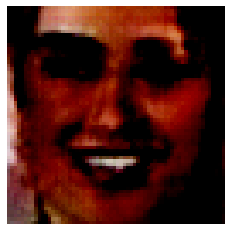

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


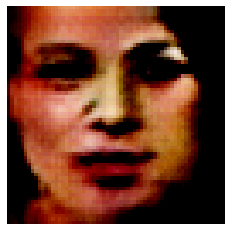

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


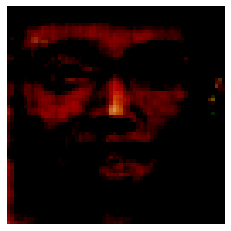

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


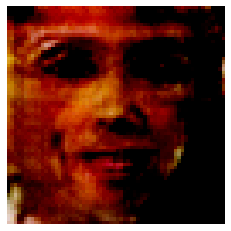

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


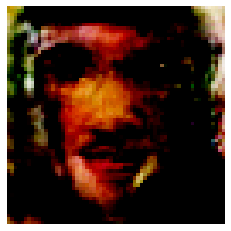

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


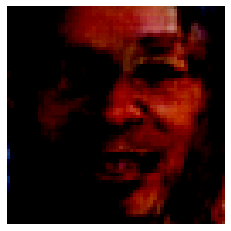

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


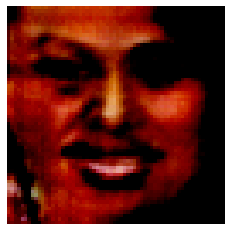

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


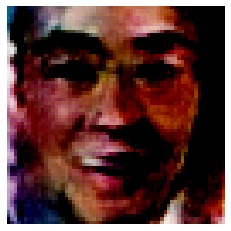

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


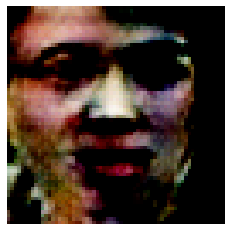

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


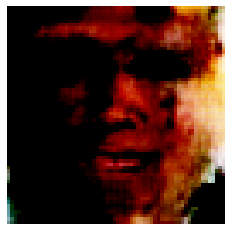

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


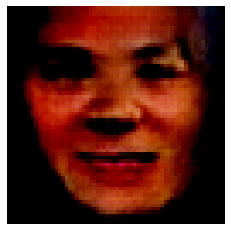

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


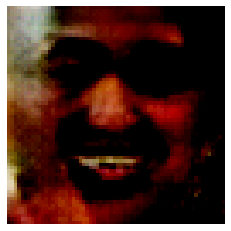

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


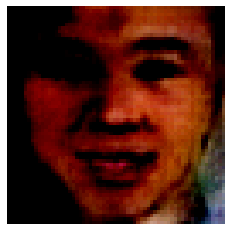

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


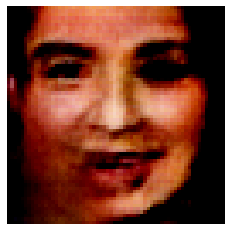

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


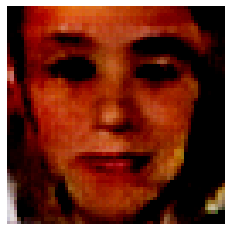

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


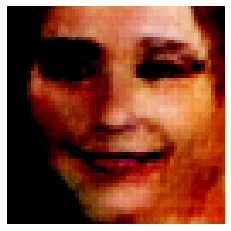

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


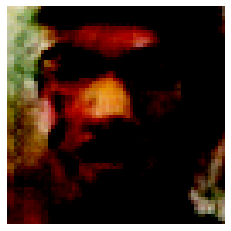

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


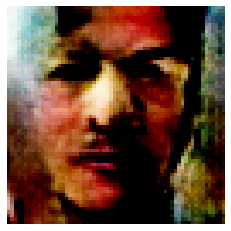

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


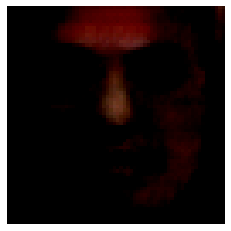

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


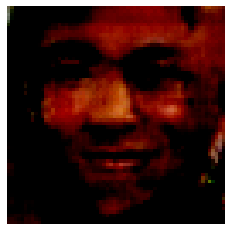

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


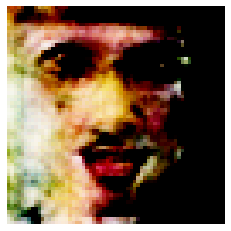

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


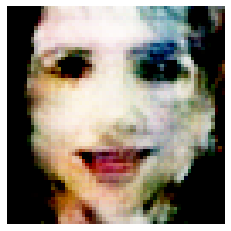

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


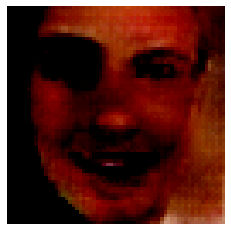

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


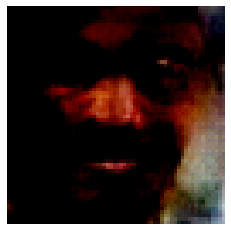

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


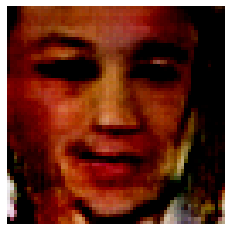

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


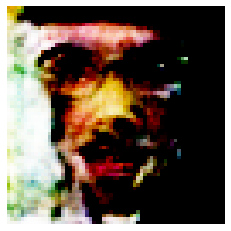

time: 9.63 s (started: 2022-01-26 12:59:42 +00:00)


In [ ]:
# Use trained generator to create new images (e.g. 100 examples)

for i in range(100):
    new_image = generator(tf.random.normal([1,100]),training=False)
    plt.axis('off')
    plt.savefig(mounting_point + f'/MyDrive/DCGAN/generated/Model1/images_after_training/image_{i}.png')
    plt.imshow(new_image[0,:,:,:])
    plt.show()


In [ ]:
# Restore the last checkpoint (if one wants to continue learning)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

time: 6.27 ms (started: 2022-01-25 11:33:03 +00:00)


# Model2

In [12]:
# Load dataset images using keras and rescale them to (64, 64, 3) shape

dataset_folder = mounting_point + '/MyDrive/DCGAN/data/actual/UTKFace' # Actual 10k+ dataset

# When label=None shape of dataset = (batch_size, image_size[0], image_size[1], num_channels)
dataset = keras.preprocessing.image_dataset_from_directory(
    dataset_folder, label_mode=None, image_size=(64, 64), batch_size=32,
    shuffle = True
)


Found 10439 files belonging to 1 classes.
time: 1.15 s (started: 2022-01-26 15:40:45 +00:00)


In [13]:
# Setting pixel values between [0, 1] (Model2 uses sigmoid as an activation function)
dataset = dataset.map(lambda x: x / 255.0)

time: 41.6 ms (started: 2022-01-26 15:40:47 +00:00)


In [14]:
# Some basic info of keras read dataset
dataset.take(1)

<TakeDataset shapes: (None, 64, 64, 3), types: tf.float32>

time: 12.2 ms (started: 2022-01-26 15:40:48 +00:00)


In [15]:
# confirming shape of 1 batch from the dataset
# Checking if dataset is normalized [0,1]
for images in dataset.take(1):
    print(images.shape)
    print(images[0])

(32, 64, 64, 3)
tf.Tensor(
[[[0.97601104 0.97601104 0.97601104]
  [0.94676775 0.9428462  0.93500304]
  [0.62670034 0.6097886  0.603416  ]
  ...
  [0.15652573 0.14476103 0.12025122]
  [0.12965687 0.11397059 0.10220588]
  [0.13310355 0.11741728 0.10565257]]

 [[0.96936274 0.96936274 0.96936274]
  [0.9663143  0.96239275 0.9545496 ]
  [0.68570775 0.66879594 0.66242343]
  ...
  [0.1360294  0.12303922 0.09852941]
  [0.11358763 0.09790135 0.08613664]
  [0.1377451  0.12205882 0.11029412]]

 [[0.97981006 0.97981006 0.97981006]
  [0.9754596  0.971538   0.9636949 ]
  [0.7810662  0.76415443 0.75778186]
  ...
  [0.12429535 0.1166973  0.0921875 ]
  [0.10784314 0.10637255 0.08946078]
  [0.13978247 0.1383119  0.12140013]]

 ...

 [[0.89681375 0.9125     0.9169118 ]
  [0.8985294  0.9142157  0.9259804 ]
  [0.8811275  0.8928922  0.9125    ]
  ...
  [0.9271752  0.9331189  0.95150125]
  [0.9387408  0.94805455 0.96643686]
  [0.952451   0.9617647  0.98014706]]

 [[0.9063266  0.92201287 0.9264246 ]
  [0.92195

## Defining a model

### Generator

Generator network:
 - Given some random noise as input it runs the noise through the differentiable function being a neural network that transform random noise into something of similar structure to the images from the training dataset.
 - Goal of it is to learn distribution of the training dataset to sample out realistic images. The training is performed using second model called discriminator.

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 256)       0 

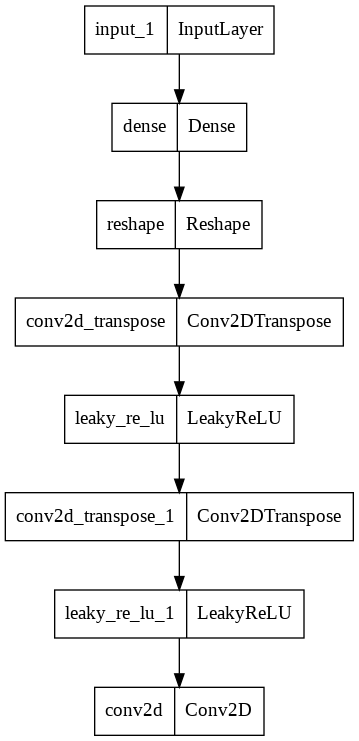

time: 377 ms (started: 2022-01-26 15:41:03 +00:00)


In [16]:
latent_dim = 128 # Noise image shape

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(16 * 16 * 128),    # creates output shape of 8,8 with number of neurons - [16,16,128]
        layers.Reshape((16, 16, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),  # stride (2,2) doubles the size of the input
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),  # stride (2,2) doubles the size of the input
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary() # Show generator's summary

# Save and show a generator's graph
tf.keras.utils.plot_model(
generator, to_file='generator2.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

gen2_img = imread('generator2.png')
cv2_imshow(gen2_img)



### Discriminator

Discriminator network:

It is a classifier network that outputs the probability of an image to be real. It runs on real images, and those generated by GAN outputing the probability of a given image to be real.

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

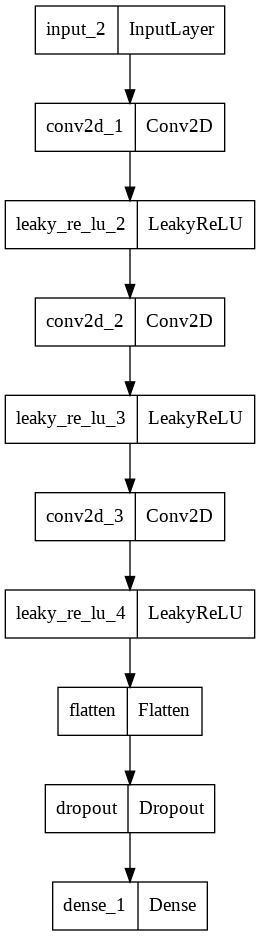

time: 195 ms (started: 2022-01-26 15:41:08 +00:00)


In [17]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary() # Discriminator's summary


# Save and plot a grapg
tf.keras.utils.plot_model(
discriminator, to_file='discriminator2.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

dis2_img = imread('discriminator2.png')
cv2_imshow(dis2_img)


### Loss and optimizers
Losses and optimizers are the same as in the Model1. There is only a difference in a checkpoint saving.

In [18]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output,fake_output):
  # Calculate real and fake losses and return a total loss
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  # Calculate generator loss
  return cross_entropy(tf.ones_like(fake_output),fake_output)

# Both optimizers are Adam optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Create checkpoint for saving the learned model
checkpoint_dir2 = mounting_point + '/MyDrive/DCGAN/training_checkpoints2'
checkpoint_prefix = os.path.join(checkpoint_dir2, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


time: 36 ms (started: 2022-01-26 15:41:13 +00:00)


## Training loop

Training loop is almost the same as in the Model1. Difference is in a noise dimensions.

In [21]:
tf.config.run_functions_eagerly(True) # To get value from a tensor representation
BATCH_SIZE = 32 # Batch size
EPOCHS = 100 # Number  of epochs
noise_dims = 128 # Noise dimensions
num_egs_to_generate = 1 # number of examples to generate during training an epoch
seed = tf.random.normal([num_egs_to_generate,noise_dims])


# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, gen_losses, disc_losses, epoch):
  noise = tf.random.normal([BATCH_SIZE,noise_dims])

  #  tf.GradientTape API is for automatic differentiation - computing the gradient of a computation with respect to some inputs
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    # Generator generates an image
    generated_images = generator(noise,training=True)

    # Discriminator gets real image
    real_output = discriminator(images,training=True)
    # Discriminator gets fake generated image
    fake_output = discriminator(generated_images,training=True)

    # Generator loss on a given image
    gen_loss = generator_loss(fake_output)
    # Discriminator loss on real vs fake image
    disc_loss = discriminator_loss(real_output,fake_output)
  
  # Arrays for storing losses
  gen_losses[epoch].append(gen_loss.numpy())
  disc_losses[epoch].append(disc_loss.numpy())


  gen_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
  dis_gradients = dis_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(dis_gradients,discriminator.trainable_variables))


def train(dataset,epochs):
  # Arrays for storing losses
  gen_losses = []
  disc_losses = []
  # Measure time for training
  start_training = time.time()
  # Train for each epoch
  for epoch in range(epochs):
    gen_losses.append([])
    disc_losses.append([])
    start = time.time()
    for batch in dataset:
      train_step(batch, gen_losses, disc_losses, epoch)
    display.clear_output(wait=True)
    generate_and_save_output(generator,epoch+1,seed)

    # Save checkpoint every 10 epochs
    if (epoch+1)%10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start}')
  
  display.clear_output(wait=True)
  generate_and_save_output(generator,epochs,seed)
  # Show training time
  print(f'Time for training: {time.time()-start_training}')
  return gen_losses, disc_losses


def generate_and_save_output(model,epoch,test_input):

  predictions = model(test_input,training=False)

  # Display image and time for a given epoch, save an image
  for i in range(predictions.shape[0]):
    plt.imshow((predictions[i]*255).numpy().astype(np.uint8))
    plt.axis('off')
  plt.savefig(mounting_point + f'/MyDrive/DCGAN/generated/Model2/image_at_epoch_{epoch}.png')
  plt.show()



time: 181 ms (started: 2022-01-26 15:42:11 +00:00)


### Train

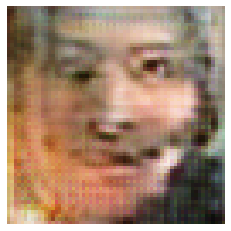

Time for training: 12431.74710226059
time: 3h 27min 11s (started: 2022-01-26 15:42:20 +00:00)


In [22]:
g_l2, d_l2 = train(dataset,EPOCHS)

## Model2 results
Training time: 3h27min

### Losses and visualization

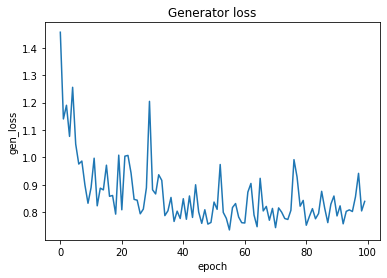

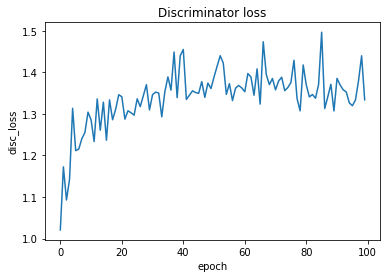

time: 457 ms (started: 2022-01-26 19:12:32 +00:00)


In [23]:
for i in range(len(g_l2)):
  g_l2[i] = sum(g_l2[i])/len(g_l2[i])

for i in range(len(d_l2)):
  d_l2[i] = sum(d_l2[i])/len(d_l2[i])

# Plot generator losses
ypoints = np.array(g_l2)

plt.plot(ypoints)
plt.xlabel('epoch') 
plt.ylabel('gen_loss') 
  
plt.title("Generator loss")
plt.show()

# Plot discriminator losses
ypoints = np.array(d_l2)

plt.plot(ypoints)
plt.xlabel('epoch') 
plt.ylabel('disc_loss') 
  
plt.title("Discriminator loss")
plt.show()

### Create new image

In [25]:
# Use trained generator to create new images (e.g. 100 examples)

for i in range(100):
    new_image = generator(tf.random.normal([1,128]),training=False)
    plt.axis('off')
    plt.imshow(new_image[0,:,:,:])
    plt.savefig(mounting_point + f'/MyDrive/DCGAN/generated/Model2/images_after_training/image_{i}.png')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Restore the last checkpoint (if one wants to continue learning)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir2))

# Experiments with a smaller dataset

In [148]:
# Load dataset images using keras and rescale them to (64, 64, 3) shape

dataset_folder = mounting_point + '/MyDrive/DCGAN/data/small' # Actual 10k+ dataset

# When label=None shape of dataset = (batch_size, image_size[0], image_size[1], num_channels)
dataset = keras.preprocessing.image_dataset_from_directory(
    dataset_folder, label_mode=None, image_size=(64, 64), batch_size=32,
    shuffle = True
)

Found 150 files belonging to 1 classes.
time: 123 ms (started: 2022-01-26 20:23:20 +00:00)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [149]:
dataset = dataset.map(lambda x: (x - 127.5) / 127.5)

time: 19.4 ms (started: 2022-01-26 20:23:21 +00:00)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:4527: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [150]:
def make_generator_model():
    model = tf.keras.models.Sequential()
    model.add(layers.Dense(8*8*128,input_shape=(100,),use_bias=False))    # creates output shape of 8,8 with number of neurons - [8,8,128]
    model.add(layers.BatchNormalization())    # applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1
    model.add(layers.LeakyReLU())    # LeakyReLu activation function
    
    model.add(layers.Reshape((8,8,128)))
    assert model.output_shape == (None, 8, 8, 128)
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(1,1),padding='same',use_bias=False))    # stride (1,1) keeps the same shape as that of input
    assert model.output_shape == (None, 8, 8, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))    # stride (2,2) doubles the size of the input 
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same',use_bias=False))    # stride (2,2) doubles the size of the input 
    assert model.output_shape == (None, 32, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),padding='same',activation='tanh',use_bias=False))    # stride (2,2) doubles the size of the input
    assert model.output_shape == (None, 64, 64, 3)
    
    return model

time: 22.6 ms (started: 2022-01-26 20:23:22 +00:00)


Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (None, 8192)              819200    
                                                                 
 batch_normalization_40 (Bat  (None, 8192)             32768     
 chNormalization)                                                
                                                                 
 leaky_re_lu_65 (LeakyReLU)  (None, 8192)              0         
                                                                 
 reshape_11 (Reshape)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 8, 8, 64)         204800    
 Transpose)                                                      
                                                                 
 batch_normalization_41 (Bat  (None, 8, 8, 64)       

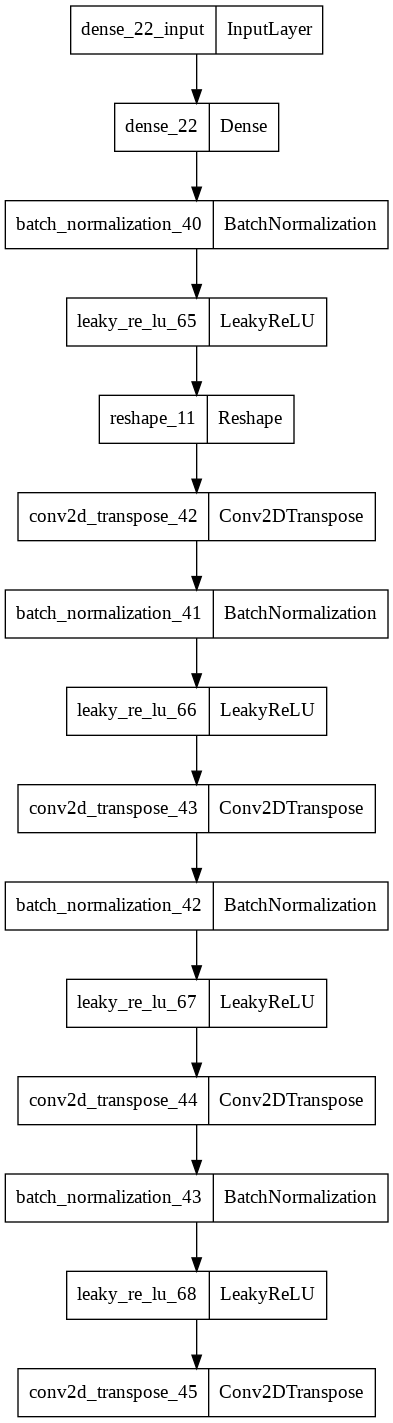

time: 420 ms (started: 2022-01-26 20:23:24 +00:00)


In [151]:
# Initialize the generator and show summary
generator = make_generator_model()
generator.summary()

# Save and show a generator's graph
tf.keras.utils.plot_model(
generator, to_file='generator.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
gen_img = imread('generator.png')
cv2_imshow(gen_img)

# Generate noise
noise = tf.random.normal([1,100])
generated_image = generator(noise,training=False)


In [152]:
def make_discriminator_model():
  model = tf.keras.models.Sequential()
  model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[64,64,3]))    # stride (2,2) doubles the size of the input
  model.add(layers.LeakyReLU())    #LeakyReLu activation function
  model.add(layers.Dropout(0.3))    # randomly sets input units to 0 with a frequency of 0.3 at each step during training time, which helps prevent overfitting

  model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))    # stride (2,2) doubles the size of the input
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())    # flattens the input, does not affect the batch size
  model.add(layers.Dense(1))    # regular densely-connected NN layer

  return model

time: 13.9 ms (started: 2022-01-26 20:23:26 +00:00)


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        4864      
                                                                 
 leaky_re_lu_69 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 dropout_21 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       204928    
                                                                 
 leaky_re_lu_70 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 dropout_22 (Dropout)        (None, 16, 16, 128)       0         
                                                                 
 flatten_11 (Flatten)        (None, 32768)           

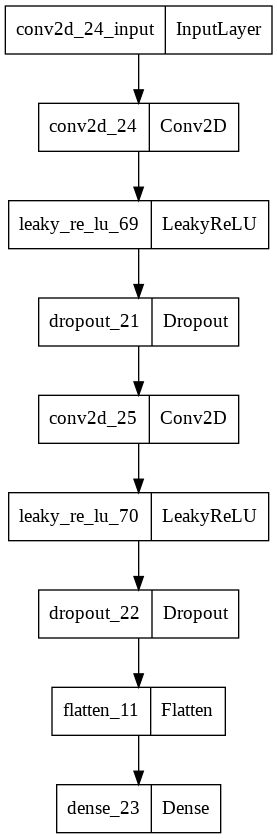

tf.Tensor([[0.00155429]], shape=(1, 1), dtype=float32)
time: 230 ms (started: 2022-01-26 20:23:28 +00:00)


In [153]:
# Initialize discriminator
discriminator = make_discriminator_model()
discriminator.summary()

# Save and show a generator's graph
tf.keras.utils.plot_model(
discriminator, to_file='discriminator.png', show_shapes=False, show_dtype=False,
show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)
dis_img = imread('discriminator.png')
cv2_imshow(dis_img)

# Examplary decision on the noise image
decision = discriminator(generated_image)
print(decision)

In [154]:
cross_entropy = tf.keras.losses.SquaredHinge()#from_logits=True)

def discriminator_loss(real_output,fake_output):
  # Calculate real and fake losses and return a total loss
  real_loss = cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

def generator_loss(fake_output):
  # Calculate generator loss
  return cross_entropy(tf.ones_like(fake_output),fake_output)

# Both optimizers are Adam optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Create checkpoint for saving the learned model
checkpoint_dir_small = mounting_point + '/MyDrive/DCGAN/training_checkpoints_small'
checkpoint_prefix = os.path.join(checkpoint_dir_small, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


time: 12.4 ms (started: 2022-01-26 20:23:33 +00:00)


In [156]:
tf.config.run_functions_eagerly(True) # To get value from a tensor representation
BATCH_SIZE = 32 # Batch size
EPOCHS = 100 # Number  of epochs
noise_dims = 100 # Noise dimensions
num_egs_to_generate = 1 # number of examples to generate during training an epoch
seed = tf.random.normal([num_egs_to_generate,noise_dims])

# This annotation causes the function to be "compiled".
@tf.function
def train_step(images, gen_losses, disc_losses, epoch):
  noise = tf.random.normal([BATCH_SIZE,noise_dims])

  #  tf.GradientTape API is for automatic differentiation - computing the gradient of a computation with respect to some inputs
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    # Generator generates an image
    generated_images = generator(noise,training=True)

    # Discriminator gets real image
    real_output = discriminator(images,training=True)
    # Discriminator gets fake generated image
    fake_output = discriminator(generated_images,training=True)

    # Generator loss on a given image
    gen_loss = generator_loss(fake_output)
    # Discriminator loss on real vs fake image
    disc_loss = discriminator_loss(real_output,fake_output)
  
  # Arrays for storing losses
  gen_losses[epoch].append(gen_loss.numpy())
  disc_losses[epoch].append(disc_loss.numpy())


  gen_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
  dis_gradients = dis_tape.gradient(disc_loss,discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gen_gradients,generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(dis_gradients,discriminator.trainable_variables))


def train(dataset,epochs):
  # Measure time for training
  start_training = time.time()
  # Arrays for storing losses
  gen_losses = []
  disc_losses = []
  # Train for each epoch
  for epoch in range(epochs):
    gen_losses.append([])
    disc_losses.append([])
    start = time.time()
    for batch in dataset:
      train_step(batch, gen_losses, disc_losses, epoch)
    display.clear_output(wait=True)
    generate_and_save_output(generator,epoch+1,seed)

    # Save checkpoint every 10 epochs
    if (epoch+1)%10 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Time for epoch {epoch + 1} is {time.time()-start}')
  
  display.clear_output(wait=True)
  generate_and_save_output(generator,epochs,seed)
  # Show training time
  print(f'Time for training: {time.time()-start_training}')
  return gen_losses, disc_losses


def generate_and_save_output(model,epoch,test_input):

  predictions = model(test_input,training=False)

  # Display image and time for a given epoch, save an image
  for i in range(predictions.shape[0]):
    plt.imshow((predictions[i]*127.5+127.5).numpy().astype(np.uint8))
    plt.axis('off')
  plt.savefig(mounting_point + f'/MyDrive/DCGAN/generated/experiments_{epoch}.png')
  plt.show()

time: 75.1 ms (started: 2022-01-26 20:23:39 +00:00)


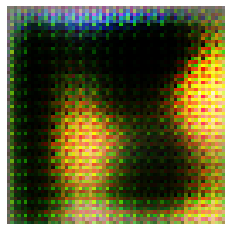

Time for training: 122.90460133552551
time: 2min 2s (started: 2022-01-26 20:23:42 +00:00)


In [157]:
g_l_ex, d_l_ex = train(dataset,EPOCHS)

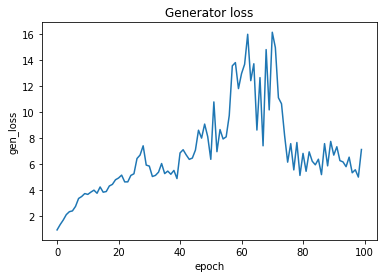

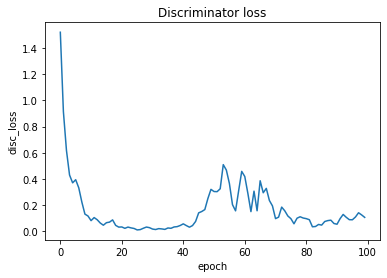

time: 1.19 s (started: 2022-01-26 20:26:16 +00:00)


In [160]:
for i in range(len(g_l_ex)):
  g_l_ex[i] = sum(g_l_ex[i])/len(g_l_ex[i])

for i in range(len(d_l_ex)):
  d_l_ex[i] = sum(d_l_ex[i])/len(d_l_ex[i])

# Plot generator losses
ypoints = np.array(g_l_ex)

plt.plot(ypoints)
plt.xlabel('epoch') 
plt.ylabel('gen_loss') 
  
plt.title("Generator loss")
plt.savefig(mounting_point + '/MyDrive/DCGAN/generated/experiments/gen_loss.png')
plt.show()

# Plot discriminator losses
ypoints = np.array(d_l_ex)

plt.plot(ypoints)
plt.xlabel('epoch') 
plt.ylabel('disc_loss') 
  
plt.title("Discriminator loss")
plt.savefig(mounting_point + '/MyDrive/DCGAN/generated/experiments/disc_loss.png')
plt.show()

# References / Bibliography

Bibliography:
 - dataset: https://susanqq.github.io/UTKFace/
 - the exact dataset: "UTKFace.tar.gz" from https://drive.google.com/drive/folders/0BxYys69jI14kU0I1YUQyY1ZDRUE?resourcekey=0-01Pth1hq20K4kuGVkp3oBw
 - Tutorial concerning DCGAN with explanation (very useful explanations): https://towardsdatascience.com/fake-face-generator-using-dcgan-model-ae9322ccfd65 
 - GAN architecture photo: https://www.researchgate.net/figure/Overview-of-the-GAN-framework_fig1_333207236 
 - https://www.tensorflow.org/tutorials/generative/dcgan -> DCGAN tutorial using KERAS and tensorflow, Model1
 - https://keras.io/examples/generative/dcgan_overriding_train_step/ -> DCGAN Face generator prepared using keras, Model2
 - https://keras.io/api/optimizers/ -> list of optimizers
 - https://keras.io/api/losses/ -> list of loss functions

# Environment description

In [ ]:
# Used python version: 

!python --version

# All installed libraries in used environment:
!pip freeze

Python 3.7.12
absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argcomplete==2.0.0
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.1.1
chardet==3.0.4
charset-normalizer==2.0.10
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.26
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defu

## Github
https://github.com/AntKlo/dcgan.git